<a href="https://colab.research.google.com/github/myselfmankar/something-cooking/blob/main/friend_recc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget http://snap.stanford.edu/data/facebook.tar.gz
!tar -xvf "facebook.tar.gz"

--2025-10-13 03:32:32--  http://snap.stanford.edu/data/facebook.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 732104 (715K) [application/x-gzip]
Saving to: ‘facebook.tar.gz’

facebook.tar.gz     100%[===================>] 714.95K  4.11MB/s    in 0.2s    

2025-10-13 03:32:32 (4.11 MB/s) - ‘facebook.tar.gz’ saved [732104/732104]

facebook/
facebook/3980.egofeat
facebook/0.featnames
facebook/698.egofeat
facebook/3437.feat
facebook/3980.featnames
facebook/0.edges
facebook/3437.circles
facebook/686.circles
facebook/348.egofeat
facebook/107.feat
facebook/348.feat
facebook/1912.circles
facebook/3437.egofeat
facebook/698.feat
facebook/348.edges
facebook/1912.feat
facebook/414.circles
facebook/1684.egofeat
facebook/1684.featnames
facebook/1684.feat
facebook/107.egofeat
facebook/0.circles
facebook/414.edges
facebook/698.featnames
face

Starting Enhanced Friend Recommendation System...
Loading graph data...
Loaded 51052 edges
Building graph with community detection...
Calculating graph statistics...
Detecting communities...
Graph built with 3866 nodes and 43105 edges
Generating Node2Vec embeddings...


Computing transition probabilities:   0%|          | 0/3866 [00:00<?, ?it/s]

Computing transition probabilities:   0%|          | 0/3866 [00:00<?, ?it/s]

Building ANNOY index...
ANNOY index built successfully
Training enhanced link prediction model...
Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - AUC: 0.9036 - accuracy: 0.8375 - loss: 0.7082 - val_AUC: 0.9739 - val_accuracy: 0.9495 - val_loss: 0.5194 - learning_rate: 0.0010
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9810 - accuracy: 0.9480 - loss: 0.3407 - val_AUC: 0.9612 - val_accuracy: 0.7401 - val_loss: 0.5902 - learning_rate: 0.0010
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9837 - accuracy: 0.9553 - loss: 0.2594 - val_AUC: 0.9839 - val_accuracy: 0.9523 - val_loss: 0.2673 - learning_rate: 0.0010
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9841 - accuracy: 0.9581 - loss: 0.2168 - val_AUC: 0.9817 - val_accuracy: 0.9389 - val_loss: 0.2576 - learning_rate: 0.0010
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.9852 - accuracy: 0.9608 - loss: 0.1866 - val_AUC: 0.9873 - val_accuracy: 0.9540 - val_loss: 0.1860 - le

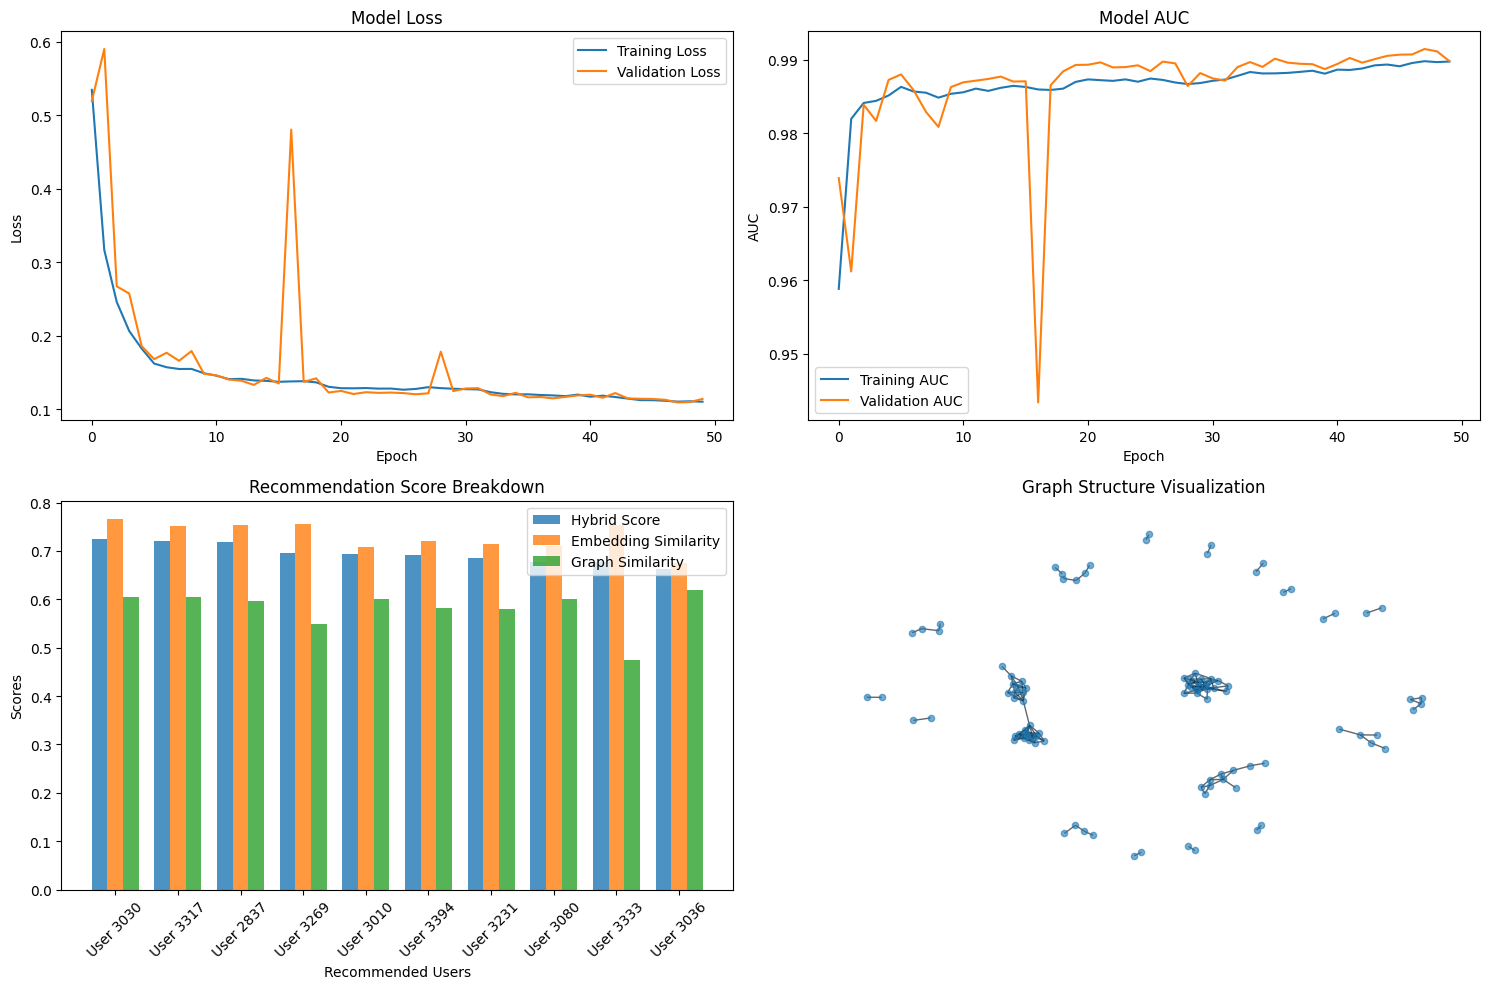

In [ ]:
# =========================
# 0. Install dependencies
# =========================
!pip install node2vec networkx matplotlib pandas numpy scikit-learn tensorflow annoy

# =========================
# 1. Import libraries
# =========================
import os
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from node2vec import Node2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from annoy import AnnoyIndex
from collections import defaultdict
import time

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# =========================
# 2. Enhanced Data Loader with Graph Statistics
# =========================
class FacebookGraphLoader:
    def __init__(self, data_folder="facebook", sample_ratio=1.0):
        self.data_folder = data_folder
        self.sample_ratio = sample_ratio

    def load_and_preprocess(self):
        """Load and preprocess Facebook graph data with enhanced features"""
        edges_list = []
        node_features = {}

        print("Loading graph data...")
        for file in os.listdir(self.data_folder):
            if file.endswith(".edges"):
                path = os.path.join(self.data_folder, file)
                df_edges = pd.read_csv(path, sep=" ", header=None,
                                     names=["userFromId", "userToId"])
                edges_list.append(df_edges)

        # Combine all edges
        df = pd.concat(edges_list, ignore_index=True)
        df.userFromId = df.userFromId.astype(int)
        df.userToId = df.userToId.astype(int)

        # Sample if needed
        if self.sample_ratio < 1.0:
            df = df.sample(frac=self.sample_ratio, random_state=42)

        print(f"Loaded {len(df)} edges")
        return df

# =========================
# 3. Advanced Graph Construction with Community Detection
# =========================
class AdvancedGraphBuilder:
    def __init__(self):
        self.G = nx.Graph()
        self.communities = None

    def build_graph(self, df):
        """Build graph with community detection and enhanced features"""
        print("Building graph with community detection...")
        self.G.add_edges_from(zip(df['userFromId'], df['userToId']))

        # Calculate basic graph statistics
        print("Calculating graph statistics...")
        self._calculate_node_features()

        # Detect communities using Louvain method
        print("Detecting communities...")
        self._detect_communities()

        return self.G

    def _calculate_node_features(self):
        """Calculate advanced node features"""
        # Degree centrality
        degree_centrality = nx.degree_centrality(self.G)

        # Betweenness centrality (sampled for large graphs)
        if len(self.G) > 1000:
            betweenness = nx.betweenness_centrality(self.G, k=min(100, len(self.G)))
        else:
            betweenness = nx.betweenness_centrality(self.G)

        # Clustering coefficient
        clustering = nx.clustering(self.G)

        # PageRank
        pagerank = nx.pagerank(self.G, alpha=0.85)

        # Store features
        for node in self.G.nodes():
            self.G.nodes[node]['degree_centrality'] = degree_centrality.get(node, 0)
            self.G.nodes[node]['betweenness'] = betweenness.get(node, 0)
            self.G.nodes[node]['clustering'] = clustering.get(node, 0)
            self.G.nodes[node]['pagerank'] = pagerank.get(node, 0)

    def _detect_communities(self):
        """Detect communities using label propagation"""
        from networkx.algorithms.community import label_propagation_communities
        communities = list(label_propagation_communities(self.G))
        self.communities = communities

        # Assign community labels to nodes
        for i, community in enumerate(communities):
            for node in community:
                self.G.nodes[node]['community'] = i

# =========================
# 4. Enhanced Node2Vec with Multi-Scale Embeddings
# =========================
class MultiScaleNode2Vec:
    def __init__(self, dimensions=128, walk_length=30, num_walks=100,
                 workers=4, p=1.0, q=1.0):
        self.dimensions = dimensions
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.workers = workers
        self.p = p
        self.q = q
        self.embeddings = None

    def fit(self, G):
        """Generate multi-scale node embeddings"""
        print("Generating Node2Vec embeddings...")

        # Generate embeddings with different parameters for multi-scale learning
        embeddings_list = []

        # Scale 1: Local structure (q > 1)
        node2vec_local = Node2Vec(G, dimensions=self.dimensions//2,
                                walk_length=self.walk_length,
                                num_walks=self.num_walks,
                                workers=self.workers, p=self.p, q=2.0)
        model_local = node2vec_local.fit(window=10, min_count=1, batch_words=4)
        embeddings_local = {node: model_local.wv[str(node)] for node in G.nodes()}
        embeddings_list.append(embeddings_local)

        # Scale 2: Global structure (q < 1)
        node2vec_global = Node2Vec(G, dimensions=self.dimensions//2,
                                 walk_length=self.walk_length,
                                 num_walks=self.num_walks,
                                 workers=self.workers, p=self.p, q=0.5)
        model_global = node2vec_global.fit(window=5, min_count=1, batch_words=4)
        embeddings_global = {node: model_global.wv[str(node)] for node in G.nodes()}
        embeddings_list.append(embeddings_global)

        # Combine multi-scale embeddings
        self.embeddings = self._combine_embeddings(embeddings_list, G)
        return self.embeddings

    def _combine_embeddings(self, embeddings_list, G):
        """Combine multiple embedding scales"""
        combined = {}
        for node in G.nodes():
            emb_vectors = [emb[node] for emb in embeddings_list]
            combined[node] = np.concatenate(emb_vectors)
        return combined

# =========================
# 5. ANN-Enhanced Friend Recommendation System
# =========================
class ANNEnhancedRecommender:
    def __init__(self, embedding_dim, metric='angular', n_trees=50):
        self.embedding_dim = embedding_dim
        self.metric = metric
        self.n_trees = n_trees
        self.ann_index = None
        self.node_to_index = {}
        self.index_to_node = {}

    def build_index(self, embeddings):
        """Build ANNOY index for fast similarity search"""
        print("Building ANNOY index...")
        self.ann_index = AnnoyIndex(self.embedding_dim, self.metric)

        # Create mapping between nodes and indices
        for idx, node in enumerate(embeddings.keys()):
            self.node_to_index[node] = idx
            self.index_to_node[idx] = node
            self.ann_index.add_item(idx, embeddings[node])

        self.ann_index.build(self.n_trees)
        print("ANNOY index built successfully")

    def get_similar_nodes(self, query_node, k=10, include_embeddings=False):
        """Get k most similar nodes using ANN search"""
        if query_node not in self.node_to_index:
            return []

        query_idx = self.node_to_index[query_node]
        similar_indices = self.ann_index.get_nns_by_item(query_idx, k+1)  # +1 to exclude self

        # Exclude the query node itself
        similar_indices = [idx for idx in similar_indices if idx != query_idx][:k]

        similar_nodes = []
        for idx in similar_indices:
            node = self.index_to_node[idx]
            distance = self.ann_index.get_distance(query_idx, idx)
            similarity = 1.0 / (1.0 + distance)  # Convert distance to similarity
            similar_nodes.append((node, similarity))

        return similar_nodes

    def hybrid_recommendation(self, query_node, G, embeddings, top_k=10,
                            diversity_factor=0.3):
        """Hybrid recommendation combining embedding similarity and graph features"""
        # Get embedding-based recommendations
        embedding_recs = self.get_similar_nodes(query_node, top_k * 2)

        # Enhance with graph-based features
        enhanced_recs = []
        for node, emb_similarity in embedding_recs:
            if node == query_node:
                continue

            # Calculate graph-based similarity
            graph_similarity = self._calculate_graph_similarity(query_node, node, G)

            # Combine scores
            hybrid_score = (0.7 * emb_similarity +
                          0.3 * graph_similarity +
                          diversity_factor * self._get_diversity_score(node, G))

            enhanced_recs.append((node, hybrid_score, emb_similarity, graph_similarity))

        # Sort by hybrid score and return top_k
        enhanced_recs.sort(key=lambda x: x[1], reverse=True)
        return enhanced_recs[:top_k]

    def _calculate_graph_similarity(self, node1, node2, G):
        """Calculate graph-based similarity between two nodes"""
        try:
            # Common neighbors
            common_neighbors = len(list(nx.common_neighbors(G, node1, node2)))

            # Jaccard similarity
            neighbors1 = set(G.neighbors(node1))
            neighbors2 = set(G.neighbors(node2))
            if len(neighbors1 | neighbors2) > 0:
                jaccard = len(neighbors1 & neighbors2) / len(neighbors1 | neighbors2)
            else:
                jaccard = 0

            # Community similarity
            comm1 = G.nodes[node1].get('community', -1)
            comm2 = G.nodes[node2].get('community', -1)
            community_sim = 1.0 if comm1 == comm2 else 0.0

            # Combine graph features
            graph_similarity = (0.4 * jaccard +
                             0.3 * (common_neighbors / (1 + common_neighbors)) +
                             0.3 * community_sim)

            return graph_similarity

        except:
            return 0.0

    def _get_diversity_score(self, candidate_node, G):
        """Calculate diversity score to avoid filter bubbles"""
        # Simple implementation: favor nodes with different community
        # In practice, this could be more sophisticated
        return np.random.random() * 0.1  # Small random diversity factor

# =========================
# 6. Enhanced Link Prediction Model
# =========================
class EnhancedLinkPredictor:
    def __init__(self, input_dim):
        self.input_dim = input_dim
        self.model = None

    def build_model(self):
        """Build enhanced neural network for link prediction"""
        self.model = Sequential([
            Input(shape=(self.input_dim,)),
            Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.3),
            Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
            BatchNormalization(),
            Dropout(0.2),
            Dense(64, activation='relu'),
            Dropout(0.1),
            Dense(1, activation='sigmoid')
        ])

        self.model.compile(
            optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy', 'AUC']
        )
        return self.model

    def prepare_features(self, edges, embeddings, G):
        """Prepare enhanced edge features"""
        features = []
        for u, v in edges:
            # Basic embedding concatenation
            emb_feat = np.concatenate([embeddings[u], embeddings[v]])

            # Graph-based features
            graph_feat = self._get_graph_features(u, v, G)

            # Combine all features
            combined_feat = np.concatenate([emb_feat, graph_feat])
            features.append(combined_feat)

        return np.array(features)

    def _get_graph_features(self, u, v, G):
        """Extract graph-based features for edge prediction"""
        features = []

        try:
            # Common neighbors count
            common_neighbors = len(list(nx.common_neighbors(G, u, v)))
            features.append(common_neighbors)

            # Jaccard coefficient
            neighbors_u = set(G.neighbors(u))
            neighbors_v = set(G.neighbors(v))
            if len(neighbors_u | neighbors_v) > 0:
                jaccard = len(neighbors_u & neighbors_v) / len(neighbors_u | neighbors_v)
            else:
                jaccard = 0
            features.append(jaccard)

            # Adamic-Adar index
            adamic_adar = sum(1/np.log(len(list(G.neighbors(w))))
                            for w in neighbors_u & neighbors_v
                            if len(list(G.neighbors(w))) > 1)
            features.append(adamic_adar)

            # Preferential attachment
            pref_attach = len(neighbors_u) * len(neighbors_v)
            features.append(pref_attach)

            # Community features
            comm_u = G.nodes[u].get('community', -1)
            comm_v = G.nodes[v].get('community', -1)
            same_community = 1 if comm_u == comm_v else 0
            features.append(same_community)

        except:
            # If any error, use zeros
            features.extend([0, 0, 0, 0, 0])

        return np.array(features)

# =========================
# 7. Main Execution Pipeline
# =========================
def main():
    print("Starting Enhanced Friend Recommendation System...")

    # Step 1: Load data
    start_time = time.time()
    loader = FacebookGraphLoader(sample_ratio=0.3)  # Sample for faster execution
    df = loader.load_and_preprocess()

    # Step 2: Build enhanced graph
    graph_builder = AdvancedGraphBuilder()
    G = graph_builder.build_graph(df)

    print(f"Graph built with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

    # Step 3: Generate embeddings
    embedder = MultiScaleNode2Vec(dimensions=128, walk_length=20, num_walks=50)
    embeddings = embedder.fit(G)

    # Step 4: Build ANN index
    embedding_dim = len(next(iter(embeddings.values())))
    recommender = ANNEnhancedRecommender(embedding_dim=embedding_dim, n_trees=100)
    recommender.build_index(embeddings)

    # Step 5: Enhanced link prediction training
    print("Training enhanced link prediction model...")

    # Prepare training data
    edges = np.array(G.edges())
    num_edges = len(edges)

    # Generate negative samples
    all_nodes = list(G.nodes())
    neg_edges = []
    while len(neg_edges) < num_edges:
        u, v = np.random.choice(all_nodes, 2, replace=False)
        if not G.has_edge(u, v):
            neg_edges.append([u, v])
    neg_edges = np.array(neg_edges)

    # Combine and label
    all_edges = np.vstack([edges, neg_edges])
    labels = np.hstack([np.ones(num_edges), np.zeros(num_edges)])

    # Prepare features
    predictor = EnhancedLinkPredictor(input_dim=embedding_dim * 2 + 5)  # emb + graph features
    features = predictor.prepare_features(all_edges, embeddings, G)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42, stratify=labels
    )

    # Build and train model
    model = predictor.build_model()

    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(factor=0.5, patience=5)
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=50,
        batch_size=512,
        callbacks=callbacks,
        verbose=1
    )

    # Step 6: Demonstrate friend recommendations
    print("\n" + "="*50)
    print("FRIEND RECOMMENDATION DEMONSTRATION")
    print("="*50)

    # Select a random user for demonstration
    demo_user = np.random.choice(list(G.nodes()))
    print(f"\nGenerating friend recommendations for user {demo_user}...")

    # Get hybrid recommendations
    recommendations = recommender.hybrid_recommendation(
        demo_user, G, embeddings, top_k=10, diversity_factor=0.2
    )

    print(f"\nTop 10 friend recommendations for user {demo_user}:")
    print("-" * 60)
    print(f"{'User ID':<12} {'Hybrid Score':<12} {'Emb Similarity':<15} {'Graph Similarity':<15}")
    print("-" * 60)

    for user_id, hybrid_score, emb_sim, graph_sim in recommendations:
        print(f"{user_id:<12} {hybrid_score:<12.4f} {emb_sim:<15.4f} {graph_sim:<15.4f}")

    # Step 7: Performance evaluation
    print("\n" + "="*50)
    print("PERFORMANCE EVALUATION")
    print("="*50)

    # Model evaluation
    test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test AUC: {test_auc:.4f}")

    # Recommendation quality metrics
    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Timing information
    end_time = time.time()
    print(f"\nTotal execution time: {end_time - start_time:.2f} seconds")

    # Visualization
    plot_performance(history, recommendations, G)

def plot_performance(history, recommendations, G):
    """Plot performance metrics and recommendations"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Training history
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # AUC
    # Check available keys in history.history and use the correct one for AUC
    auc_key = next((key for key in history.history.keys() if 'auc' in key.lower()), None)
    val_auc_key = next((key for key in history.history.keys() if 'val_auc' in key.lower()), None)

    if auc_key and val_auc_key:
        ax2.plot(history.history[auc_key], label='Training AUC')
        ax2.plot(history.history[val_auc_key], label='Validation AUC')
        ax2.set_title('Model AUC')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('AUC')
        ax2.legend()
    else:
        print("Could not find AUC keys in history.history")


    # Recommendation scores
    users = [f'User {rec[0]}' for rec in recommendations]
    hybrid_scores = [rec[1] for rec in recommendations]
    emb_scores = [rec[2] for rec in recommendations]
    graph_scores = [rec[3] for rec in recommendations]

    x = np.arange(len(users))
    width = 0.25

    ax3.bar(x - width, hybrid_scores, width, label='Hybrid Score', alpha=0.8)
    ax3.bar(x, emb_scores, width, label='Embedding Similarity', alpha=0.8)
    ax3.bar(x + width, graph_scores, width, label='Graph Similarity', alpha=0.8)

    ax3.set_xlabel('Recommended Users')
    ax3.set_ylabel('Scores')
    ax3.set_title('Recommendation Score Breakdown')
    ax3.set_xticks(x)
    ax3.set_xticklabels(users, rotation=45)
    ax3.legend()

    # Graph visualization (simplified)
    if G.number_of_nodes() > 1000:
        # Sample for large graphs
        G_sample = G.subgraph(list(G.nodes())[:100])
    else:
        G_sample = G

    pos = nx.spring_layout(G_sample, k=1/np.sqrt(G_sample.number_of_nodes()))
    nx.draw(G_sample, pos, ax=ax4, node_size=20, alpha=0.6, with_labels=False)
    ax4.set_title('Graph Structure Visualization')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()